<a href="https://colab.research.google.com/github/zooodung/TA-Prediction/blob/sangyoun/Encoding_modeling_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 교통사고 위험도 예측

## 라이브러리 및 파일 호출

In [1]:
!pip install pytimekr

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pytimekr import pytimekr
from sklearn.preprocessing import LabelEncoder
import os

In [3]:
path='/content/drive/MyDrive/camp/project1/open/'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
daegu_data=pd.read_csv(path+'train.csv')
wide_data=pd.read_csv(path+'external_open/countrywide_accident.csv')
test_data=pd.read_csv(path+'test.csv')
daegu_data.head()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


## 기초 통계 분석

In [6]:
#ta_data_daegu.info()

In [7]:
#x_test.info()

In [8]:
#ta_data_daegu.describe()

In [9]:
#ta_data_daegu.describe()

In [10]:
#columns = ['요일', '기상상태', '도로형태', '노면상태', '사고유형']

#for column in columns:
#    print(f"Column: {column}")
#    print(ta_data_daegu[column].value_counts())
#    print("-" * 30)

## 전처리

### 대구 데이터 전처리

#### 불필요한 컬럼 제거

In [11]:
columns_to_drop = ['ID', '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령',
                   '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도']


daegu=daegu_data.drop(columns=columns_to_drop)

#### 사고일시 컬럼 연도, 월, 일, 시간 단위로 분할

In [12]:
#daegu[['년도','월','일+시간']] = daegu['사고일시'].str.split('-',expand=True)
#daegu[['일','시간']]= daegu['일+시간'].str.split(' ',expand=True)

#daegu.drop(['일+시간','사고일시'],inplace=True, axis=1)
#daegu.drop(['일'],inplace=True, axis=1)

#### 시군구 단위로 분할

In [13]:
daegu[['시','구','동']] = daegu['시군구'].str.split(' ',expand=True)
daegu.drop(['시군구'],inplace=True, axis=1)

#### 도로 형태 분할

In [14]:
daegu[['도로형태1', '도로형태2']] = daegu['도로형태'].str.split(' - ', expand=True)
daegu.drop(['도로형태'],inplace=True, axis=1)

In [15]:
daegu.head()

,사고일시,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,시,구,동,도로형태1,도로형태2
0,2019-01-01 00,화요일,맑음,건조,차대사람,0,1,0,0,5,대구광역시,중구,대신동,단일로,기타
1,2019-01-01 00,화요일,흐림,건조,차대사람,0,0,1,0,3,대구광역시,달서구,감삼동,단일로,기타
2,2019-01-01 01,화요일,맑음,건조,차대사람,0,0,1,0,3,대구광역시,수성구,두산동,단일로,기타
3,2019-01-01 02,화요일,맑음,건조,차대차,0,1,0,0,5,대구광역시,북구,복현동,단일로,기타
4,2019-01-01 04,화요일,맑음,건조,차대차,0,0,1,0,3,대구광역시,동구,신암동,단일로,기타


#### 요일 컬럼 평일과 주말로 분류

In [16]:
#ta_data_daegu['요일 분류'] = ta_data_daegu['요일'].apply(lambda x: '평일' if x in ['월요일', '화요일', '수요일', '목요일', '금요일'] else '주말')

In [17]:
#ta_data_daegu

### 전국 데이터 전처리

In [18]:
wide=wide_data.copy()
len(wide)

602775

#### 철길 건널목 제거

In [19]:
wide = wide[~wide['도로형태'].str.split().str[-1].str.contains('철길건널목')]

#### 불필요한 컬럼 제거

In [20]:
wide=wide.drop(columns=columns_to_drop)

#### 광역시, 특별시만 분류

In [21]:
def contains_specific_location(address):
    cities = ['서울특별시', '인천광역시', '부산광역시', '울산광역시', '광주광역시', '대전광역시']
    for city in cities:
        if city in address:
            return True
    return False
wide=wide[wide['시군구'].apply(contains_specific_location)]

wide[['시','구','동']] = wide['시군구'].str.split(' ',expand=True)

In [22]:
wide['시군구'].apply(lambda x:x.split()[0]).value_counts()

서울특별시    108395
부산광역시     36244
인천광역시     25115
광주광역시     23430
대전광역시     22579
울산광역시     11981
Name: 시군구, dtype: int64

In [23]:
wide.drop(['시군구'],inplace=True, axis=1)

#### 연도, 월, 일, 시간 분류

In [24]:
#wide[['년도','월','일+시간']] = wide['사고일시'].str.split('-',expand=True)
#wide[['일','시간']]= wide['일+시간'].str.split(' ',expand=True)

#wide.drop(['일+시간','사고일시'],inplace=True, axis=1)
#wide.drop(['일'],inplace=True, axis=1)

#### 도로 형태 분류

In [25]:
wide[['도로형태1', '도로형태2']] = wide['도로형태'].str.split(' - ', expand=True)

wide.drop(['도로형태'],inplace=True, axis=1)

In [26]:
wide.head()

,사고일시,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,시,구,동,도로형태1,도로형태2
0,2019-01-01 00,화요일,맑음,건조,차대사람,0,0,1,0,3,서울특별시,강서구,방화동,교차로,교차로횡단보도내
4,2019-01-01 00,화요일,맑음,건조,차대차,0,0,2,1,7,인천광역시,부평구,부평동,교차로,교차로안
5,2019-01-01 00,화요일,맑음,건조,차대사람,0,0,1,0,3,인천광역시,부평구,부평동,교차로,교차로부근
8,2019-01-01 00,화요일,맑음,건조,차대차,0,0,1,0,3,광주광역시,광산구,수완동,단일로,기타
11,2019-01-01 00,화요일,맑음,건조,차대사람,1,0,0,0,10,부산광역시,해운대구,우동,교차로,교차로안


### 데이터 병합 후 전처리 진행

In [27]:
print(len(daegu),len(wide), len(daegu)+len(wide))

39609 227744 267353


In [28]:
concatenated_df = pd.concat([daegu, wide])
concatenated_df

,사고일시,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,시,구,동,도로형태1,도로형태2
0,2019-01-01 00,화요일,맑음,건조,차대사람,0,1,0,0,5,대구광역시,중구,대신동,단일로,기타
1,2019-01-01 00,화요일,흐림,건조,차대사람,0,0,1,0,3,대구광역시,달서구,감삼동,단일로,기타
2,2019-01-01 01,화요일,맑음,건조,차대사람,0,0,1,0,3,대구광역시,수성구,두산동,단일로,기타
3,2019-01-01 02,화요일,맑음,건조,차대차,0,1,0,0,5,대구광역시,북구,복현동,단일로,기타
4,2019-01-01 04,화요일,맑음,건조,차대차,0,0,1,0,3,대구광역시,동구,신암동,단일로,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602766,2021-12-31 23,금요일,맑음,건조,차대사람,0,0,1,0,3,서울특별시,서초구,반포동,단일로,기타
602769,2021-12-31 23,금요일,맑음,건조,차대차,0,1,0,0,5,부산광역시,연제구,연산동,단일로,기타
602770,2021-12-31 23,금요일,흐림,건조,차대차,0,1,1,0,8,부산광역시,해운대구,우동,교차로,교차로안
602771,2021-12-31 23,금요일,맑음,건조,차대차,0,0,2,0,6,서울특별시,성동구,행당동,단일로,기타


#### 휴일 여부

In [29]:
for i in range(2019, 2024):
    kr_holidays = pytimekr.holidays(i)
    print(kr_holidays)

[datetime.date(2019, 2, 4), datetime.date(2019, 2, 5), datetime.date(2019, 2, 6), datetime.date(2019, 9, 12), datetime.date(2019, 9, 13), datetime.date(2019, 9, 14), datetime.date(2019, 1, 1), datetime.date(2019, 3, 1), datetime.date(2019, 5, 5), datetime.date(2019, 5, 12), datetime.date(2019, 6, 6), datetime.date(2019, 8, 15), datetime.date(2019, 10, 9), datetime.date(2019, 10, 3), datetime.date(2019, 12, 25)]
[datetime.date(2020, 1, 24), datetime.date(2020, 1, 25), datetime.date(2020, 1, 26), datetime.date(2020, 9, 30), datetime.date(2020, 10, 1), datetime.date(2020, 10, 2), datetime.date(2020, 1, 1), datetime.date(2020, 3, 1), datetime.date(2020, 5, 5), datetime.date(2020, 4, 30), datetime.date(2020, 6, 6), datetime.date(2020, 8, 15), datetime.date(2020, 10, 9), datetime.date(2020, 10, 3), datetime.date(2020, 12, 25)]
[datetime.date(2021, 2, 11), datetime.date(2021, 2, 12), datetime.date(2021, 2, 13), datetime.date(2021, 9, 20), datetime.date(2021, 9, 21), datetime.date(2021, 9, 22)

In [30]:
kr_holidays = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01', '2023-05-05', '2023-05-26', '2023-06-06', '2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-03', '2023-10-09', '2023-12-25']


In [31]:
concatenated_df['사고일시'] = pd.to_datetime(concatenated_df['사고일시'])

# datetime에서 year, month, day, hour 추출하여 새로운 열 생성
concatenated_df['년도'] = concatenated_df['사고일시'].dt.year
concatenated_df['월'] = concatenated_df['사고일시'].dt.month
concatenated_df['day'] = concatenated_df['사고일시'].dt.day
concatenated_df['시간'] = concatenated_df['사고일시'].dt.hour
concatenated_df['day_of_week'] = concatenated_df['사고일시'].dt.dayofweek

In [32]:
concatenated_df['holiday'] = np.where((concatenated_df.day_of_week >= 5) | (concatenated_df.사고일시.dt.strftime('%Y-%m-%d').isin(kr_holidays)), '휴일', '평일')

In [33]:
concatenated_df.drop(columns=['사고일시'], inplace=True)

In [34]:
concatenated_df['holiday'].value_counts()

평일    195393
휴일     71960
Name: holiday, dtype: int64

In [35]:
concatenated_df.drop(['day', 'day_of_week'], inplace=True, axis=1)

#### 주말 여부

In [36]:
#concatenated_df['주말여부']=concatenated_df['요일'].apply(lambda x:'주말' if x in ['토요일','일요일'] else '평일')

#concatenated_df['주말여부'].value_counts()

#### 시간 분류

In [37]:
def seperate_time(time): #심야, 새벽, 오전, 오후, 저녁, 야간 ->4시간단위
    if 0<=int(time)<4:
        return '심야'
    elif int(time)<8:
        return '새벽'
    elif int(time)<12:
        return '오전'
    elif int(time)<16:
        return '오후'
    elif int(time)<20:
        return '저녁'
    else:
        return '야간'
concatenated_df['시간구분']=concatenated_df['시간'].apply(seperate_time)
print(concatenated_df['시간구분'].value_counts().sum())
concatenated_df['시간구분'].value_counts()

267353


저녁    71768
오후    58743
오전    50058
야간    47737
새벽    20554
심야    18493
Name: 시간구분, dtype: int64

#### 계절 분류

In [38]:
def seperate_month(month):
    if int(month) in [12,1,2]:
        return '겨울'
    elif int(month) in [3,4,5]:
        return '봄'
    elif int(month) in [6,7,8]:
        return '여름'
    else:
        return '가을'
concatenated_df['계절']=concatenated_df['월'].apply(seperate_month)
print(concatenated_df['계절'].value_counts().sum())
concatenated_df['계절'].value_counts()

267353


가을    70234
여름    68434
봄     66607
겨울    62078
Name: 계절, dtype: int64

### 병합된 데이터 전처리 확인

In [39]:
concatenated_df

,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,시,구,동,도로형태1,도로형태2,년도,월,시간,holiday,시간구분,계절
0,화요일,맑음,건조,차대사람,0,1,0,0,5,대구광역시,중구,대신동,단일로,기타,2019,1,0,휴일,심야,겨울
1,화요일,흐림,건조,차대사람,0,0,1,0,3,대구광역시,달서구,감삼동,단일로,기타,2019,1,0,휴일,심야,겨울
2,화요일,맑음,건조,차대사람,0,0,1,0,3,대구광역시,수성구,두산동,단일로,기타,2019,1,1,휴일,심야,겨울
3,화요일,맑음,건조,차대차,0,1,0,0,5,대구광역시,북구,복현동,단일로,기타,2019,1,2,휴일,심야,겨울
4,화요일,맑음,건조,차대차,0,0,1,0,3,대구광역시,동구,신암동,단일로,기타,2019,1,4,휴일,새벽,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602766,금요일,맑음,건조,차대사람,0,0,1,0,3,서울특별시,서초구,반포동,단일로,기타,2021,12,23,평일,야간,겨울
602769,금요일,맑음,건조,차대차,0,1,0,0,5,부산광역시,연제구,연산동,단일로,기타,2021,12,23,평일,야간,겨울
602770,금요일,흐림,건조,차대차,0,1,1,0,8,부산광역시,해운대구,우동,교차로,교차로안,2021,12,23,평일,야간,겨울
602771,금요일,맑음,건조,차대차,0,0,2,0,6,서울특별시,성동구,행당동,단일로,기타,2021,12,23,평일,야간,겨울


### 테스트 데이터 전처리 진행

In [40]:
test=test_data.copy()

In [41]:
test[['시','구','동']] = test['시군구'].str.split(' ',expand=True)
test.drop(['시군구'],inplace=True, axis=1)

In [42]:
test[['도로형태1', '도로형태2']] = test['도로형태'].str.split(' - ', expand=True)
test.drop(['도로형태'],inplace=True, axis=1)

In [43]:
kr_holidays = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01', '2023-05-05', '2023-05-26', '2023-06-06', '2023-08-15', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-03', '2023-10-09', '2023-12-25']


In [44]:
test['사고일시'] = pd.to_datetime(test['사고일시'])

# datetime에서 year, month, day, hour 추출하여 새로운 열 생성
test['년도'] = test['사고일시'].dt.year
test['월'] = test['사고일시'].dt.month
test['day'] = test['사고일시'].dt.day
test['시간'] = test['사고일시'].dt.hour
test['day_of_week'] = test['사고일시'].dt.dayofweek

test['holiday'] = np.where((test.day_of_week >= 5) | (test.사고일시.dt.strftime('%Y-%m-%d').isin(kr_holidays)), '휴일', '평일')

test.drop(columns=['사고일시'], inplace=True)
test.drop(['day', 'day_of_week'], inplace=True, axis=1)

In [45]:
test['시간구분']=test['시간'].apply(seperate_time)

In [46]:
test['계절']=test['월'].apply(seperate_month)
test['계절'].value_counts()

가을    2947
여름    2783
봄     2771
겨울    2462
Name: 계절, dtype: int64

In [47]:
test.drop('ID',axis=1,inplace=True)

#### 테스트 데이터 전처리 결과 확인

In [48]:
test

,요일,기상상태,노면상태,사고유형,시,구,동,도로형태1,도로형태2,년도,월,시간,holiday,시간구분,계절
0,토요일,맑음,건조,차대사람,대구광역시,수성구,상동,교차로,교차로안,2022,1,1,휴일,심야,겨울
1,토요일,맑음,건조,차대사람,대구광역시,수성구,지산동,단일로,기타,2022,1,1,휴일,심야,겨울
2,토요일,맑음,건조,차대차,대구광역시,수성구,수성동2가,교차로,교차로안,2022,1,4,휴일,새벽,겨울
3,토요일,맑음,건조,차대차,대구광역시,수성구,신매동,단일로,기타,2022,1,4,휴일,새벽,겨울
4,토요일,맑음,건조,차대차,대구광역시,달서구,감삼동,교차로,교차로안,2022,1,6,휴일,새벽,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,토요일,맑음,건조,차대차,대구광역시,남구,대명동,단일로,터널,2022,12,18,휴일,저녁,겨울
10959,토요일,맑음,건조,차대차,대구광역시,수성구,시지동,단일로,기타,2022,12,18,휴일,저녁,겨울
10960,토요일,맑음,건조,차대차,대구광역시,수성구,연호동,단일로,기타,2022,12,20,휴일,야간,겨울
10961,토요일,맑음,건조,차대차,대구광역시,수성구,범물동,교차로,교차로부근,2022,12,20,휴일,야간,겨울


#### 합쳐진 훈련 데이터 셋 오류 수정

In [49]:
concatenated_df = concatenated_df[~concatenated_df['기상상태'].str.split().str[-1].str.contains('안개')]
concatenated_df = concatenated_df[~concatenated_df['노면상태'].str.split().str[-1].str.contains('해빙')]

In [50]:
concatenated_df

,요일,기상상태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,시,구,동,도로형태1,도로형태2,년도,월,시간,holiday,시간구분,계절
0,화요일,맑음,건조,차대사람,0,1,0,0,5,대구광역시,중구,대신동,단일로,기타,2019,1,0,휴일,심야,겨울
1,화요일,흐림,건조,차대사람,0,0,1,0,3,대구광역시,달서구,감삼동,단일로,기타,2019,1,0,휴일,심야,겨울
2,화요일,맑음,건조,차대사람,0,0,1,0,3,대구광역시,수성구,두산동,단일로,기타,2019,1,1,휴일,심야,겨울
3,화요일,맑음,건조,차대차,0,1,0,0,5,대구광역시,북구,복현동,단일로,기타,2019,1,2,휴일,심야,겨울
4,화요일,맑음,건조,차대차,0,0,1,0,3,대구광역시,동구,신암동,단일로,기타,2019,1,4,휴일,새벽,겨울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602766,금요일,맑음,건조,차대사람,0,0,1,0,3,서울특별시,서초구,반포동,단일로,기타,2021,12,23,평일,야간,겨울
602769,금요일,맑음,건조,차대차,0,1,0,0,5,부산광역시,연제구,연산동,단일로,기타,2021,12,23,평일,야간,겨울
602770,금요일,흐림,건조,차대차,0,1,1,0,8,부산광역시,해운대구,우동,교차로,교차로안,2021,12,23,평일,야간,겨울
602771,금요일,맑음,건조,차대차,0,0,2,0,6,서울특별시,성동구,행당동,단일로,기타,2021,12,23,평일,야간,겨울


#### 전처리 데이터 저장 - 전처리 매번 로딩할 필요 없다

In [51]:
# concatenated_df.to_csv(path + f'/데이터들/인코딩 없음/train.csv')
# test.to_csv(path + f'/데이터들/인코딩 없음/test.csv')

In [52]:
# path = os.getcwd()

# concatenated_df.to_csv(path + f'/데이터들/인코딩 없음/train.csv')
# test = pd.read_csv(path + f'/데이터들/인코딩 없음/test.csv')

#전처리 - 원핫인코딩

In [53]:
total_data = pd.concat([concatenated_df, test])
total_data = pd.get_dummies(total_data)

In [54]:
for c in total_data.columns:
    print(c)
print(len(total_data.columns))

사망자수
중상자수
경상자수
부상자수
ECLO
년도
월
시간
요일_금요일
요일_목요일
요일_수요일
요일_월요일
요일_일요일
요일_토요일
요일_화요일
기상상태_기타
기상상태_눈
기상상태_맑음
기상상태_비
기상상태_흐림
노면상태_건조
노면상태_기타
노면상태_서리/결빙
노면상태_적설
노면상태_젖음/습기
노면상태_침수
사고유형_차대사람
사고유형_차대차
사고유형_차량단독
시_광주광역시
시_대구광역시
시_대전광역시
시_부산광역시
시_서울특별시
시_울산광역시
시_인천광역시
구_강남구
구_강동구
구_강북구
구_강서구
구_강화군
구_계양구
구_관악구
구_광산구
구_광진구
구_구로구
구_금정구
구_금천구
구_기장군
구_남구
구_남동구
구_노원구
구_달서구
구_달성군
구_대덕구
구_도봉구
구_동구
구_동대문구
구_동래구
구_동작구
구_마포구
구_미추홀구
구_부산진구
구_부평구
구_북구
구_사상구
구_사하구
구_서구
구_서대문구
구_서초구
구_성동구
구_성북구
구_송파구
구_수성구
구_수영구
구_양천구
구_연수구
구_연제구
구_영도구
구_영등포구
구_옹진군
구_용산구
구_울주군
구_유성구
구_은평구
구_종로구
구_중구
구_중랑구
구_해운대구
동_가대동
동_가락동
동_가리봉동
동_가산동
동_가수원동
동_가야동
동_가양동
동_가오동
동_가장동
동_가정동
동_가좌동
동_가창면
동_가천동
동_가회동
동_각산동
동_각화동
동_간석동
동_갈마동
동_갈산동
동_갈월동
동_갈전동
동_갈현동
동_감만동
동_감삼동
동_감전동
동_감천동
동_갑동
동_강동동
동_강일동
동_강화읍
동_개금동
동_개봉동
동_개포동
동_개화동
동_거여동
동_거제동
동_검단동
동_검사동
동_검암동
동_견지동
동_경동
동_경서동
동_경운동
동_계동
동_계림동
동_계산동
동_계산동1가
동_계산동2가
동_고덕동
동_고룡동
동_고모동
동_고사동
동_고성동1가
동_고성동2가
동_고성동3가
동_고잔동
동_고척동
동_공덕동
동_공릉동
동_공촌동
동_공평동
동_공항동
동_과해동
동_관교동
동_관동1가
동_관동2가
동_관동3가
동_관수동
동_

In [55]:
train_data = total_data[~total_data['ECLO'].isnull()]
test_data = total_data[total_data['ECLO'].isnull()]

In [56]:
test_data = test_data.drop(['사망자수','중상자수','경상자수','부상자수','ECLO'], axis=1)

In [57]:
train_data

,사망자수,중상자수,경상자수,부상자수,ECLO,년도,월,시간,요일_금요일,요일_목요일,...,시간구분_새벽,시간구분_심야,시간구분_야간,시간구분_오전,시간구분_오후,시간구분_저녁,계절_가을,계절_겨울,계절_봄,계절_여름
0,0.0,1.0,0.0,0.0,5.0,2019,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,0.0,0.0,1.0,0.0,3.0,2019,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0.0,0.0,1.0,0.0,3.0,2019,1,1,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0.0,1.0,0.0,0.0,5.0,2019,1,2,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0.0,0.0,1.0,0.0,3.0,2019,1,4,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602766,0.0,0.0,1.0,0.0,3.0,2021,12,23,1,0,...,0,0,1,0,0,0,0,1,0,0
602769,0.0,1.0,0.0,0.0,5.0,2021,12,23,1,0,...,0,0,1,0,0,0,0,1,0,0
602770,0.0,1.0,1.0,0.0,8.0,2021,12,23,1,0,...,0,0,1,0,0,0,0,1,0,0
602771,0.0,0.0,2.0,0.0,6.0,2021,12,23,1,0,...,0,0,1,0,0,0,0,1,0,0


In [58]:
test_data

,년도,월,시간,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일,...,시간구분_새벽,시간구분_심야,시간구분_야간,시간구분_오전,시간구분_오후,시간구분_저녁,계절_가을,계절_겨울,계절_봄,계절_여름
0,2022,1,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
1,2022,1,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,2022,1,4,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,2022,1,4,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,2022,1,6,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,2022,12,18,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
10959,2022,12,18,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
10960,2022,12,20,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
10961,2022,12,20,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [59]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267300 entries, 0 to 602772
Columns: 1399 entries, 사망자수 to 계절_여름
dtypes: float64(5), int64(3), uint8(1391)
memory usage: 372.9 MB


#2

#XGBRegressor

In [60]:
y1=train_data[['ECLO']]
y2=train_data[['사망자수']]
y3=train_data[['중상자수']]
y4=train_data[['경상자수']]
y5=train_data[['부상자수']]
X=train_data.drop(columns=['사망자수','중상자수','경상자수','부상자수','ECLO'])

In [61]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
X_train, X_test, y_train, y_test = train_test_split(X,y1, test_size=0.2, random_state=42)

In [62]:
from sklearn.metrics import mean_squared_log_error
def rmsle(y, pred):
    return np.sqrt(mean_squared_log_error(y, pred))

In [63]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmsle1 = rmsle(y_test, y_pred)
rmsle1

0.4348713105128585

In [64]:
model2 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
rmsle2 = rmsle(y_test, y_pred2)
rmsle2

0.434538117392477

In [65]:
model3 = XGBRegressor(n_estimators=100, learning_rate=0.01, max_depth=3)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
rmsle3 = rmsle(y_test, y_pred3)
rmsle3

0.43711097496948254

In [66]:
model4 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=12)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
rmsle4 = rmsle(y_test, y_pred4)
rmsle4

0.4363392048466455

In [67]:
model5 = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
model5.fit(X_train, y_train)
y_pred5 = model5.predict(X_test)
rmsle5= rmsle(y_test, y_pred5)
rmsle5

0.43473976778740736

lightgbm

In [68]:
from lightgbm import LGBMRegressor
model6=LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
model6.fit(X_train, y_train)
y_pred6 = model6.predict(X_test)
rmsle6 = rmsle(y_test, y_pred6)
rmsle6

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2061
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 1013
[LightGBM] [Info] Start training from score 4.632730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

0.4346003518401168

In [69]:
model7=LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
model7.fit(X_train, y_train)
y_pred7 = model7.predict(X_test)
rmsle7 = rmsle(y_test, y_pred7)
rmsle7

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2061
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 1013
[LightGBM] [Info] Start training from score 4.632730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

0.43428407893855836

In [70]:
model8=LGBMRegressor(n_estimators=100, learning_rate=0.1,num_leaves=36,  max_depth=6)
model8.fit(X_train, y_train)
y_pred8 = model8.predict(X_test)
rmsle8 = rmsle(y_test, y_pred8)
rmsle8

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2061
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 1013
[LightGBM] [Info] Start training from score 4.632730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

0.4342441297394159

In [71]:
model9=LGBMRegressor(n_estimators=100, learning_rate=0.1,num_leaves=36,  max_depth=12)
model9.fit(X_train, y_train)
y_pred9 = model9.predict(X_test)
rmsle9 = rmsle(y_test, y_pred9)
rmsle9

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2061
[LightGBM] [Info] Number of data points in the train set: 213840, number of used features: 1013
[LightGBM] [Info] Start training from score 4.632730


0.4342228621901983

In [73]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.5 MB/s eta 0:00:00


In [74]:
from catboost import CatBoostRegressor

In [76]:
model11 = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, random_state=42)
model11.fit(X_train, y_train)
y_pred11 = model11.predict(X_test)
rmsle11 = rmsle(y_test, y_pred11)
rmsle11

0:	learn: 3.1874521	total: 118ms	remaining: 11.7s
1:	learn: 3.1822879	total: 151ms	remaining: 7.39s
2:	learn: 3.1776685	total: 203ms	remaining: 6.55s
3:	learn: 3.1739196	total: 237ms	remaining: 5.69s
4:	learn: 3.1709297	total: 279ms	remaining: 5.3s
5:	learn: 3.1685527	total: 340ms	remaining: 5.33s
6:	learn: 3.1664879	total: 396ms	remaining: 5.25s
7:	learn: 3.1647148	total: 455ms	remaining: 5.23s
8:	learn: 3.1630243	total: 511ms	remaining: 5.16s
9:	learn: 3.1617027	total: 573ms	remaining: 5.16s
10:	learn: 3.1605799	total: 646ms	remaining: 5.22s
11:	learn: 3.1596167	total: 730ms	remaining: 5.35s
12:	learn: 3.1587911	total: 786ms	remaining: 5.26s
13:	learn: 3.1580475	total: 840ms	remaining: 5.16s
14:	learn: 3.1573610	total: 883ms	remaining: 5.01s
15:	learn: 3.1565852	total: 980ms	remaining: 5.14s
16:	learn: 3.1559727	total: 1.08s	remaining: 5.29s
17:	learn: 3.1554255	total: 1.16s	remaining: 5.3s
18:	learn: 3.1550048	total: 1.25s	remaining: 5.33s
19:	learn: 3.1544822	total: 1.33s	remaining

0.43525459959568

In [77]:
model12 = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_state=42)
model12.fit(X_train, y_train)
y_pred12 = model12.predict(X_test)
rmsle12 = rmsle(y_test, y_pred12)
rmsle12

0:	learn: 3.1861643	total: 92.7ms	remaining: 9.18s
1:	learn: 3.1799080	total: 174ms	remaining: 8.51s
2:	learn: 3.1746146	total: 254ms	remaining: 8.22s
3:	learn: 3.1701110	total: 337ms	remaining: 8.09s
4:	learn: 3.1663750	total: 426ms	remaining: 8.08s
5:	learn: 3.1632824	total: 503ms	remaining: 7.88s
6:	learn: 3.1609457	total: 583ms	remaining: 7.74s
7:	learn: 3.1588095	total: 666ms	remaining: 7.66s
8:	learn: 3.1570433	total: 752ms	remaining: 7.6s
9:	learn: 3.1553602	total: 838ms	remaining: 7.54s
10:	learn: 3.1540384	total: 906ms	remaining: 7.33s
11:	learn: 3.1529592	total: 988ms	remaining: 7.24s
12:	learn: 3.1515695	total: 1.07s	remaining: 7.19s
13:	learn: 3.1506739	total: 1.15s	remaining: 7.04s
14:	learn: 3.1497793	total: 1.23s	remaining: 6.95s
15:	learn: 3.1491020	total: 1.31s	remaining: 6.86s
16:	learn: 3.1483627	total: 1.38s	remaining: 6.72s
17:	learn: 3.1475761	total: 1.45s	remaining: 6.58s
18:	learn: 3.1469035	total: 1.51s	remaining: 6.46s
19:	learn: 3.1456744	total: 1.59s	remaini

0.43460708901621975

In [78]:
model13 = CatBoostRegressor(iterations=100, learning_rate=0.01, depth=3, random_state=42)
model13.fit(X_train, y_train)
y_pred13 = model13.predict(X_test)
rmsle13 = rmsle(y_test, y_pred13)
rmsle13

0:	learn: 3.1934452	total: 31.2ms	remaining: 3.09s
1:	learn: 3.1927586	total: 71.8ms	remaining: 3.52s
2:	learn: 3.1920855	total: 100ms	remaining: 3.23s
3:	learn: 3.1914257	total: 124ms	remaining: 2.97s
4:	learn: 3.1907788	total: 147ms	remaining: 2.78s
5:	learn: 3.1901634	total: 169ms	remaining: 2.65s
6:	learn: 3.1896122	total: 197ms	remaining: 2.61s
7:	learn: 3.1890092	total: 220ms	remaining: 2.52s
8:	learn: 3.1884363	total: 246ms	remaining: 2.49s
9:	learn: 3.1878648	total: 269ms	remaining: 2.42s
10:	learn: 3.1872946	total: 292ms	remaining: 2.36s
11:	learn: 3.1867356	total: 316ms	remaining: 2.32s
12:	learn: 3.1862004	total: 339ms	remaining: 2.27s
13:	learn: 3.1856611	total: 361ms	remaining: 2.22s
14:	learn: 3.1851181	total: 385ms	remaining: 2.18s
15:	learn: 3.1845859	total: 408ms	remaining: 2.14s
16:	learn: 3.1841343	total: 430ms	remaining: 2.1s
17:	learn: 3.1836515	total: 456ms	remaining: 2.08s
18:	learn: 3.1831751	total: 479ms	remaining: 2.04s
19:	learn: 3.1826783	total: 501ms	remain

0.4373905080136101

In [79]:
model14 = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=12, random_state=42)
model14.fit(X_train, y_train)
y_pred14 = model14.predict(X_test)
rmsle14 = rmsle(y_test, y_pred14)
rmsle14

0:	learn: 3.1839588	total: 393ms	remaining: 38.9s
1:	learn: 3.1753332	total: 713ms	remaining: 34.9s
2:	learn: 3.1702506	total: 761ms	remaining: 24.6s
3:	learn: 3.1645791	total: 1.02s	remaining: 24.4s
4:	learn: 3.1592680	total: 1.28s	remaining: 24.3s
5:	learn: 3.1540015	total: 1.55s	remaining: 24.3s
6:	learn: 3.1503976	total: 1.82s	remaining: 24.2s
7:	learn: 3.1469685	total: 2.06s	remaining: 23.8s
8:	learn: 3.1440698	total: 2.3s	remaining: 23.2s
9:	learn: 3.1409142	total: 2.53s	remaining: 22.8s
10:	learn: 3.1384776	total: 2.78s	remaining: 22.5s
11:	learn: 3.1357139	total: 3.02s	remaining: 22.2s
12:	learn: 3.1332555	total: 3.29s	remaining: 22s
13:	learn: 3.1305936	total: 3.55s	remaining: 21.8s
14:	learn: 3.1283401	total: 3.82s	remaining: 21.6s
15:	learn: 3.1264710	total: 4.07s	remaining: 21.4s
16:	learn: 3.1245575	total: 4.3s	remaining: 21s
17:	learn: 3.1231488	total: 4.54s	remaining: 20.7s
18:	learn: 3.1217863	total: 4.79s	remaining: 20.4s
19:	learn: 3.1196621	total: 5.03s	remaining: 20

0.4344795014375106

In [80]:
model15 = CatBoostRegressor(iterations=200, learning_rate=0.1, depth=3, random_state=42)
model15.fit(X_train, y_train)
y_pred15 = model15.predict(X_test)
rmsle15 = rmsle(y_test, y_pred15)
rmsle15

0:	learn: 3.1874521	total: 24.8ms	remaining: 4.93s
1:	learn: 3.1822879	total: 49.3ms	remaining: 4.88s
2:	learn: 3.1776685	total: 72.9ms	remaining: 4.79s
3:	learn: 3.1739196	total: 113ms	remaining: 5.54s
4:	learn: 3.1709297	total: 137ms	remaining: 5.35s
5:	learn: 3.1685527	total: 163ms	remaining: 5.27s
6:	learn: 3.1664879	total: 188ms	remaining: 5.18s
7:	learn: 3.1647148	total: 212ms	remaining: 5.09s
8:	learn: 3.1630243	total: 240ms	remaining: 5.1s
9:	learn: 3.1617027	total: 265ms	remaining: 5.04s
10:	learn: 3.1605799	total: 290ms	remaining: 4.98s
11:	learn: 3.1596167	total: 313ms	remaining: 4.9s
12:	learn: 3.1587911	total: 336ms	remaining: 4.84s
13:	learn: 3.1580475	total: 360ms	remaining: 4.79s
14:	learn: 3.1573610	total: 383ms	remaining: 4.73s
15:	learn: 3.1565852	total: 407ms	remaining: 4.68s
16:	learn: 3.1559727	total: 432ms	remaining: 4.65s
17:	learn: 3.1554255	total: 459ms	remaining: 4.64s
18:	learn: 3.1550048	total: 484ms	remaining: 4.61s
19:	learn: 3.1544822	total: 508ms	remain

0.4349478657138072

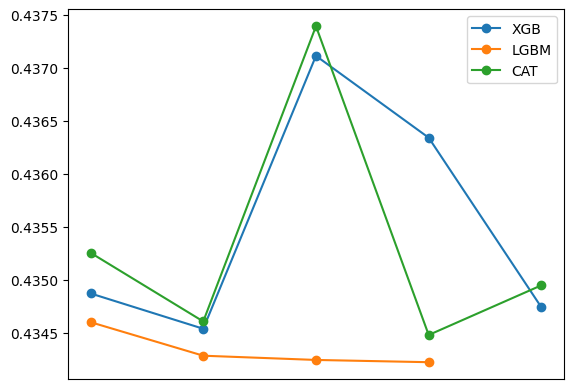

In [81]:
 plt.plot([1,2,3,4,5],[rmsle1,rmsle2,rmsle3,rmsle4,rmsle5],linestyle='-',marker='o',label='XGB')
 plt.plot([1,2,3,4],[rmsle6,rmsle7,rmsle8,rmsle9],linestyle='-',marker='o',label='LGBM')
plt.plot([1,2,3,4,5],[rmsle11,rmsle12,rmsle13,rmsle14,rmsle15],linestyle='-',marker='o',label='CAT')
 plt.legend()
 plt.xticks([])
 plt.show()